# Anomaly detection exercise

We would like to investigate putting an 'anomalous event' detection algorithm in the trigger of a particle physics collider experiment. For this purpose, we will use a 'background' or 'Standard Model' dataset, on which we will train our algorithm to learn about 'normal events'. Then we will apply it to a dataset containing 'abnormal' or 'New Physics' events, containing new particle decays, and see if our algorithm can detect them as being 'abnormal'. Finally, as we're triggering in real time ('online'), we will check the timing of our algorithm.

## Datasets
Datasets were generated in the context of an online reference / competition, and currently consist of A->4 leptons, leptoquarks -> b tau, h0 -> tau tau, and h+ -> tau nu, pick your favourite New Physics case (or try them all!)

## Environment
The default environment will be **Google Colab**. You can also make use of the Nikhef in-house jupterlab service **Callysto** at https://callysto.nikhef.nl where you can customize your environment following https://wiki.nikhef.nl/ct/Jupyterlab. You can also run your own jupyter instance locally.

**TIP**: to speed up learining in Google Colab, enable hardware acceleration with GPUs by going to \\
`Runtime > Change runtime type > Hardware accelerator > GPU`.

*As prepared by, with full credits to,* https://mpp-hep.github.io/ADC2021/ \\
*(Edited by jdevries)*


In [1]:
env = "COLAB"
#env = "CALLYSTO"

In [2]:
if(env == "CALLYSTO") :
  !pip install h5py tensorflow sklearn

In [3]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, ReLU, LeakyReLU,Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten
from tensorflow.keras import backend as K

import argparse
from sklearn.model_selection import train_test_split

In [4]:
# Download datasets. These are cleared when deleting the runtime.
#  If connection is too slow: they are also hosted on stoomboot at /data/bfys/jdevries/public

# Background (Standard Model) dataset
bkg_file = "background_for_training.h5"
if not os.path.exists(bkg_file) :
  !wget https://zenodo.org/record/5046389/files/background_for_training.h5

# Anomaly dataset: choose your favourite New Physics candidate from https://mpp-hep.github.io/ADC2021/
signal_file = 'leptoquark_LOWMASS_lepFilter_13TeV.h5'
if not os.path.exists(signal_file) :
  !wget https://zenodo.org/record/5055454/files/leptoquark_LOWMASS_lepFilter_13TeV.h5

!ls

background_for_training.h5	       myAnomalyModel.h5    SM_dataset.h5
leptoquark_LOWMASS_lepFilter_13TeV.h5  myAnomalyModel.json
LQ_dataset.h5			       sample_data


In [5]:
# Must be TF version 2
print(tf.__version__)

2.8.2


In [6]:
# define some data handling functions

def load_model(model_name, custom_objects=None):
    name = model_name + '.json'
    json_file = open(name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects=custom_objects)
    model.load_weights(model_name + '.h5')
    return model

def save_model(model_save_name, model):
    with open(model_save_name + '.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights(model_save_name + '.h5')


def create_datasets_dense(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=57):
    
    # read BACKGROUND data
    with h5py.File(bkg_file, 'r') as file:
        full_data = file['Particles'][:,:,:-1]
        np.random.shuffle(full_data)
        if events: full_data = full_data[:events,:,:]
    
    # define training, test and validation datasets
    X_train, X_test = train_test_split(full_data, test_size=test_size, shuffle=True)
    X_train, X_val = train_test_split(X_train, test_size=val_size)

    del full_data
    
    # flatten the data for model input
    X_train = X_train.reshape(X_train.shape[0], input_shape)
    X_test = X_test.reshape(X_test.shape[0], input_shape)
    X_val = X_val.reshape(X_val.shape[0], input_shape)
    
    with h5py.File(output_bkg_name + '_dataset.h5', 'w') as h5f:
        h5f.create_dataset('X_train', data = X_train)
        h5f.create_dataset('X_test', data = X_test)
        h5f.create_dataset('X_val', data = X_val)
    
    if signals_files:
        # read SIGNAL data
        for i, signal_file in enumerate(signals_files):
            f = h5py.File(signal_file,'r')
            signal_data = f['Particles'][:,:,:-1]
            signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
            with h5py.File(output_signal_names[i] + '_dataset.h5', 'w') as h5f2:
                h5f2.create_dataset('Data', data = signal_data)        
    return

In [7]:
# Create numpy arrays from datasets for easy handling

output_bkg_name = 'SM'
output_sig_name = 'LQ'
filename_bkg = output_bkg_name + '_dataset.h5'
filename_sig = output_sig_name + '_dataset.h5'
events = 1000000

if not os.path.exists(filename_sig) :
  create_datasets_dense(bkg_file, output_bkg_name, [signal_file], [output_sig_name], events)

In [8]:
# load background training data
with h5py.File(filename_bkg, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test  = np.array(file['X_test'])
    X_val   = np.array(file['X_val'])

print(X_train.shape)
X_train = np.reshape(X_train, (-1, 19,3,1))
X_test  = np.reshape(X_test,  (-1, 19,3,1))
X_val   = np.reshape(X_val,   (-1, 19,3,1))

print(X_train.shape)

(640000, 57)
(640000, 19, 3, 1)


We have now loaded the Standard Model (SM) dataset as train, test and validation random splits. 

The data contains the **19** most interesting 'particles' per collision event:
- 'missing transverse energy' object (`MET`)
- 4 electrons
- 4 muons
- 10 jets

which are ordered by `p_T`, from high to low, and might be zero-padded in case there are fewer particles of that type in the event.

For each 'particle' there are **3** features in the dataset: 
- transverse momentum (`p_T`)
- pseudorapidity 'angle' (`eta`)
- azimuthal angle (`phi`)


Text(0.5, 0, 'p_T [GeV/c]')

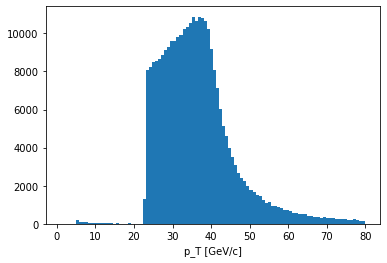

In [9]:
# For example, let's draw the pT of the highest-pT muon in all training events

plt.hist( [ event[5, 0][0] for event in X_train ], bins=100, range=[1, 80] )
plt.xlabel("p_T [GeV/c]")

# Define NN architecture

For anomaly detection, we want our algorithm to **only** see the SM dataset to learn about normal, 'non-anomalous' behavior. After training/testing/validation, we then want to move on to the new physics dataset (e.g. leptoquarks) - and see how it performs in labelling that input as 'anomalous'.

In [10]:
image_shape = (19,3,1)

In [11]:

### HERE GOES YOUR WORK ###

# Write your preferred anomaly detection algorithm here
#  that takes as input something of shape=(image_shape)
#  and as output something that is relevant for your algorithm, e.g. 
#  - a value in the N-dimensional hyperspace of your clustering, 
#  - the 'latent space' of your autoencoder (and the original image after the decoder)
#  - ...

# Trivial autoencoder example (to get you going):
latent_dimension = 8

#encoder
input_encoder = Input(shape=(image_shape))
x = Conv2D(10, kernel_size=(3, 3),
         use_bias=False, data_format='channels_last', padding='same')(input_encoder)
x = AveragePooling2D(pool_size = (2, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(latent_dimension)(x)
enc = Activation('relu')(x)
encoder = Model(inputs=input_encoder, outputs=enc)

#decoder
x = Dense(270)(enc)
x = Activation('relu')(x)
x = Reshape((9,3,10))(x)
x = UpSampling2D((2, 1))(x)
x = ZeroPadding2D(((1, 0),(0,0)))(x)
x = Conv2D(1, kernel_size=(3,3), use_bias=False, data_format='channels_last', padding='same')(x)
x = BatchNormalization()(x)
dec = Activation('relu')(x)

autoencoder = Model(inputs=input_encoder, outputs=dec)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 3, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 19, 3, 10)         90        
                                                                 
 average_pooling2d (AverageP  (None, 9, 3, 10)         0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 9, 3, 10)         40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 9, 3, 10)          0         
                                                                 
 flatten (Flatten)           (None, 270)               0   

In [12]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

In [13]:
EPOCHS = 10
BATCH_SIZE = 1024

In [14]:
# Train model
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
625/625 [==============================] - 9s 6ms/step - loss: 64.3654 - val_loss: 55.5387
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 52.4524 - val_loss: 47.6854
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 43.5577 - val_loss: 38.4012
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 36.1345 - val_loss: 31.5064
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 29.7308 - val_loss: 25.7864
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 24.1457 - val_loss: 20.7536
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 19.2669 - val_loss: 16.4523
Epoch 8/10
625/625 [==============================] - 3s 4ms/step - loss: 15.0602 - val_loss: 12.6137
Epoch 9/10
625/625 [==============================] - 3s 4ms/step - loss: 11.4727 - val_loss: 9.3947
Epoch 10/10
625/625 [==============================] - 3s 4ms/step - loss: 8.4707 -

In [15]:
# Save model
model_name = 'myAnomalyModel'
save_model(model_name, autoencoder)
!ls

background_for_training.h5	       myAnomalyModel.h5    SM_dataset.h5
leptoquark_LOWMASS_lepFilter_13TeV.h5  myAnomalyModel.json
LQ_dataset.h5			       sample_data


In [29]:
# Test model on the remainder of our Standard Model dataset, this is our 'reference performance'.
%%time
print("Running predictions for {0} bkg events".format(len(X_test)))
bkg_prediction = autoencoder.predict(X_test)

Running predictions for 200000 bkg events
CPU times: user 11.7 s, sys: 875 ms, total: 12.6 s
Wall time: 20.6 s


# Running on the anomalous data

Here we run the 'new physics' data through our trained algorithm, and save the relevant output.

In [22]:
# Obtain the anomalous signal datasets
with h5py.File(filename_sig) as file :
  signal_data = np.array(file['Data'])

signal_data = np.reshape(signal_data, (-1, 19,3,1))

In [36]:
# Run model predictions on anomalous signal
%%time
print("Running predictions for {0} sig events".format(len(signal_data)))
sig_prediction = autoencoder.predict(signal_data)

Running predictions for 340544 sig events
CPU times: user 18 s, sys: 1.37 s, total: 19.4 s
Wall time: 15.2 s


In [37]:
# Save results
save_file = 'myAnomalyModel_results'

with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    file.create_dataset('SIG_input', data=signal_data)
    file.create_dataset('SIG_predicted' , data=sig_prediction)

# Evaluation of performance

Here is where you assess the metric of performance of your algorithm. 

For an autoencoder, the 'score' would be *How well can I reconstruct the original image back?*. This would be 'pretty good' if the image is similar to the training data, and 'not so good' if the data looks like something new. As this performance is characterised by the loss function, this is what we will be looking at.

For other methods this can be different. For instance, for a Restricted Boltzmann machine it could be the 'Energy', for kernel methods / clustering methods / one-class support vector machines, some 'distance' in some output space, and so on. For your algorithm, consider what it should be doing, and evaluate performance accordingly.

In [34]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

In [41]:
# compute loss value (true, predicted)
data_labels = ["SM", "LQ"]

total_loss = []
total_loss.append(mse_loss(X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2])),\
                           (bkg_prediction.reshape((bkg_prediction.shape[0],bkg_prediction.shape[1]*bkg_prediction.shape[2]))).astype(np.float32)).numpy())
total_loss.append(mse_loss(signal_data.reshape((signal_data.shape[0],signal_data.shape[1]*signal_data.shape[2])),\
                           (sig_prediction.reshape((sig_prediction.shape[0],sig_prediction.shape[1]*sig_prediction.shape[2]))).astype(np.float32)).numpy())

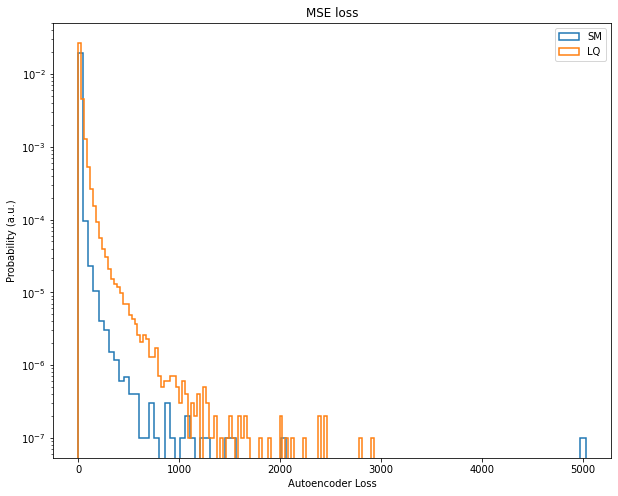

In [42]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(data_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

# When is something anomalous?

In order to define something as being 'anomalous', we have to decide on a 'cut point' in the metric defined above. In the case of an autoencoder, we could place a cut on a certain value of the loss: anything higher than, say, 1500, could be considered anomalous. 

In order to assess the performance regardless of the cut point, we can make a ROC curve - this evaluates the 'true' anomaly rate as function of the 'false' anomaly rate.

The area under this curve ('AUC') is a generic metric for comparing performances between models.

In [44]:
from sklearn.metrics import roc_curve, auc

In [46]:
labels = np.concatenate([['Standard Model'], ['Leptoquark']])

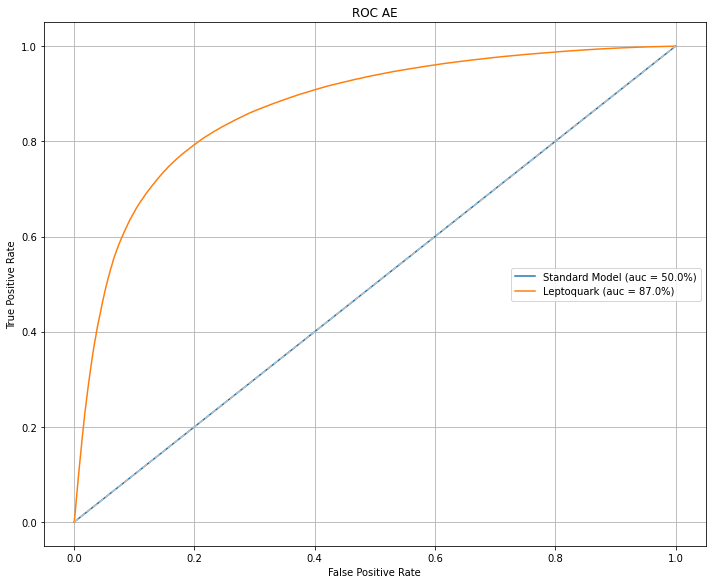

In [50]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    #plt.semilogx()
    #plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()

plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.title("ROC AE")
plt.show()

# How to improve

Now, it's up to you to improve. Can you
- Improve upon the model, to enhance the AUC score? Can you change the model to a different approach, such as a restricted Boltzmann machine or a one-class support vector machine? (And change the 'when is something anomalous' metric accordingly)
- Improve the timing of the inference/prediction so it is viable to run in the trigger, without causing too much AUC loss? Can you make a plot of the AUC vs the time of various approaches?
- Add the other anomalous datasets in this challenge, and compare how well you can identify e.g. anomalous charged higgs events vs leptoquarks? Maybe some are easier to detect than others?